In this example, we will compare effectiveness of stop loss and trailing stop loss across multiple cryptocurrencies and time ranges. 

We will conduct in total 370,000 tests. First, we will pick and fetch 2 years of daily pricing data for 10 cryptocurrencies of main interest. For each one, we will split the entire history into 367 (overlapping) time ranges each 1 year long and select the first date of each range as a buy signal. For each such signal, we will test 100 different stop loss and trailing stop values with 1% increment. These will be our exit signals stored in separate variables. We will also generate random exit signals in our third variable to be able to compare effectiveness of stop loss with that of a random exit strategy. Finally, we will calculate performance of all strategies and compare them interactivelly. Thanks to vectorbt, such tests can be done in a matter of minutes. You can also change any of the parameters mentioned above at the beginning of the notebook.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
import itertools
import yfinance as yf
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import ipywidgets

In [3]:
# Define your params here
seed = 42
asset_names = [
    'BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 
    'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD']
price_name = 'Open'

history_len = timedelta(days=365*2)
end_date = datetime.now()
start_date = end_date - history_len
time_window = timedelta(days=365) # length of a time window
freq = '1D'

stops = np.arange(0, 1, 0.01) # in %

vbt.defaults.portfolio['init_capital'] = 100 # in $
vbt.defaults.portfolio['fees'] = 0.0025 # in %
vbt.defaults.portfolio['slippage'] = 0.0025 # in %

print(len(asset_names) * (history_len.days - time_window.days), 'experiments per stop value')
print(len(stops), 'stop values per stop type')
print(len(asset_names) * (history_len.days - time_window.days) * len(stops), 'experiments per stop type')

3650 experiments per stop value
100 stop values per stop type
365000 experiments per stop type


In [4]:
%%time
# Download data
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
asset_history = {k: yf.Ticker(k).history(start=start_date, end=end_date) for k in asset_names}
asset_history = {k: v[ohlcv_cols] for k, v in asset_history.items()}
asset_history = {k: v.astype(np.float64) for k, v in asset_history.items()}

for k, v in asset_history.items():
    print(k, v.shape)
    
print(asset_history['BTC-USD'].columns)

BTC-USD (730, 5)
ETH-USD (730, 5)
XRP-USD (730, 5)
BCH-USD (730, 5)
LTC-USD (730, 5)
BNB-USD (730, 5)
EOS-USD (730, 5)
XLM-USD (730, 5)
XMR-USD (730, 5)
ADA-USD (730, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
CPU times: user 787 ms, sys: 111 ms, total: 897 ms
Wall time: 3.2 s


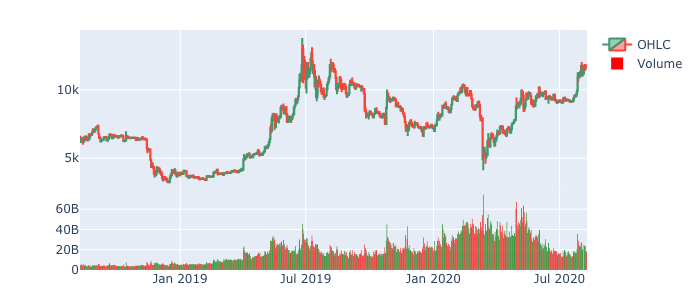

In [5]:
asset_history['BTC-USD'].vbt.ohlcv.plot().show_png()

In [27]:
%%time
# Stack all dfs along each column
price = pd.concat(map(lambda x: x[price_name], asset_history.values()), axis=1)
price.columns = pd.Index(asset_history.keys(), name='asset_name')

print(price.shape)
print(price.columns) # number of stocks

(730, 10)
Index(['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD',
       'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'],
      dtype='object', name='asset_name')
CPU times: user 53.5 ms, sys: 91.4 ms, total: 145 ms
Wall time: 149 ms


In [28]:
%%time
# Split the whole time period into time ranges
price = price.vbt.split_into_ranges(range_len=time_window.days)
    
print(price.shape)
print(price.columns) # number of stocks x number of ranges

(365, 3660)
MultiIndex([('BTC-USD', '2018-08-10', '2019-08-09'),
            ('BTC-USD', '2018-08-11', '2019-08-10'),
            ('BTC-USD', '2018-08-12', '2019-08-11'),
            ('BTC-USD', '2018-08-13', '2019-08-12'),
            ('BTC-USD', '2018-08-14', '2019-08-13'),
            ('BTC-USD', '2018-08-15', '2019-08-14'),
            ('BTC-USD', '2018-08-16', '2019-08-15'),
            ('BTC-USD', '2018-08-17', '2019-08-16'),
            ('BTC-USD', '2018-08-18', '2019-08-17'),
            ('BTC-USD', '2018-08-19', '2019-08-18'),
            ...
            ('ADA-USD', '2019-08-01', '2020-07-30'),
            ('ADA-USD', '2019-08-02', '2020-07-31'),
            ('ADA-USD', '2019-08-03', '2020-08-01'),
            ('ADA-USD', '2019-08-04', '2020-08-02'),
            ('ADA-USD', '2019-08-05', '2020-08-03'),
            ('ADA-USD', '2019-08-06', '2020-08-05'),
            ('ADA-USD', '2019-08-07', '2020-08-06'),
            ('ADA-USD', '2019-08-08', '2020-08-07'),
            ('ADA-

In [29]:
%%time
# Pick one entry signal at the beginning of each time range
entries = pd.DataFrame.vbt.signals.empty(price.shape)
entries.iloc[0, :] = True

# Right now our rand signals have no meaningful columns
entries.columns = price.columns

print(entries.shape)
print(entries.columns)

(365, 3660)
MultiIndex([('BTC-USD', '2018-08-10', '2019-08-09'),
            ('BTC-USD', '2018-08-11', '2019-08-10'),
            ('BTC-USD', '2018-08-12', '2019-08-11'),
            ('BTC-USD', '2018-08-13', '2019-08-12'),
            ('BTC-USD', '2018-08-14', '2019-08-13'),
            ('BTC-USD', '2018-08-15', '2019-08-14'),
            ('BTC-USD', '2018-08-16', '2019-08-15'),
            ('BTC-USD', '2018-08-17', '2019-08-16'),
            ('BTC-USD', '2018-08-18', '2019-08-17'),
            ('BTC-USD', '2018-08-19', '2019-08-18'),
            ...
            ('ADA-USD', '2019-08-01', '2020-07-30'),
            ('ADA-USD', '2019-08-02', '2020-07-31'),
            ('ADA-USD', '2019-08-03', '2020-08-01'),
            ('ADA-USD', '2019-08-04', '2020-08-02'),
            ('ADA-USD', '2019-08-05', '2020-08-03'),
            ('ADA-USD', '2019-08-06', '2020-08-05'),
            ('ADA-USD', '2019-08-07', '2020-08-06'),
            ('ADA-USD', '2019-08-08', '2020-08-07'),
            ('ADA-

In [30]:
# Pick one exit signal at the end of each time range
exits = pd.DataFrame.vbt.signals.empty_like(entries)
exits.iloc[-1, :] = True

print(exits.shape)
print(exits.columns)

(365, 3660)
MultiIndex([('BTC-USD', '2018-08-10', '2019-08-09'),
            ('BTC-USD', '2018-08-11', '2019-08-10'),
            ('BTC-USD', '2018-08-12', '2019-08-11'),
            ('BTC-USD', '2018-08-13', '2019-08-12'),
            ('BTC-USD', '2018-08-14', '2019-08-13'),
            ('BTC-USD', '2018-08-15', '2019-08-14'),
            ('BTC-USD', '2018-08-16', '2019-08-15'),
            ('BTC-USD', '2018-08-17', '2019-08-16'),
            ('BTC-USD', '2018-08-18', '2019-08-17'),
            ('BTC-USD', '2018-08-19', '2019-08-18'),
            ...
            ('ADA-USD', '2019-08-01', '2020-07-30'),
            ('ADA-USD', '2019-08-02', '2020-07-31'),
            ('ADA-USD', '2019-08-03', '2020-08-01'),
            ('ADA-USD', '2019-08-04', '2020-08-02'),
            ('ADA-USD', '2019-08-05', '2020-08-03'),
            ('ADA-USD', '2019-08-06', '2020-08-05'),
            ('ADA-USD', '2019-08-07', '2020-08-06'),
            ('ADA-USD', '2019-08-08', '2020-08-07'),
            ('ADA-

In [31]:
%%time
# Calculate stop loss exits
stop_loss_exits = entries.vbt.signals.generate_stop_loss_exits(price, stops)
trail_stop_exits = entries.vbt.signals.generate_stop_loss_exits(price, stops, trailing=True)

print(stop_loss_exits.shape, trail_stop_exits.shape)
print(stop_loss_exits.columns)

# Update the number of columns to match those of stop exits
entries = entries.vbt.tile(len(stops))
exits = exits.vbt.tile(len(stops))
price = price.vbt.tile(len(stops))

assert(stop_loss_exits.shape == entries.shape)
assert(stop_loss_exits.shape == price.shape)

(365, 366000) (365, 366000)
MultiIndex([( 0.0, 'BTC-USD', '2018-08-10', '2019-08-09'),
            ( 0.0, 'BTC-USD', '2018-08-11', '2019-08-10'),
            ( 0.0, 'BTC-USD', '2018-08-12', '2019-08-11'),
            ( 0.0, 'BTC-USD', '2018-08-13', '2019-08-12'),
            ( 0.0, 'BTC-USD', '2018-08-14', '2019-08-13'),
            ( 0.0, 'BTC-USD', '2018-08-15', '2019-08-14'),
            ( 0.0, 'BTC-USD', '2018-08-16', '2019-08-15'),
            ( 0.0, 'BTC-USD', '2018-08-17', '2019-08-16'),
            ( 0.0, 'BTC-USD', '2018-08-18', '2019-08-17'),
            ( 0.0, 'BTC-USD', '2018-08-19', '2019-08-18'),
            ...
            (0.99, 'ADA-USD', '2019-08-01', '2020-07-30'),
            (0.99, 'ADA-USD', '2019-08-02', '2020-07-31'),
            (0.99, 'ADA-USD', '2019-08-03', '2020-08-01'),
            (0.99, 'ADA-USD', '2019-08-04', '2020-08-02'),
            (0.99, 'ADA-USD', '2019-08-05', '2020-08-03'),
            (0.99, 'ADA-USD', '2019-08-06', '2020-08-05'),
            

0.47770218579234974
0.6796475409836066


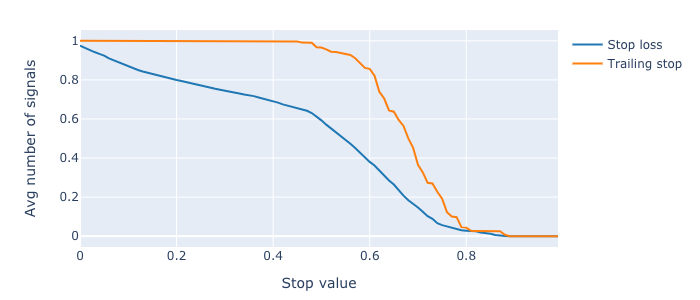

CPU times: user 558 ms, sys: 15.8 ms, total: 574 ms
Wall time: 747 ms


In [32]:
%%time
# How many exit signals our orders have generated?
print(stop_loss_exits.vbt.signals.num_signals.mean())
print(trail_stop_exits.vbt.signals.num_signals.mean())

stop_cols = stop_loss_exits.columns.get_level_values('stop_loss')

pd.DataFrame({
    'Stop loss': stop_loss_exits.vbt.signals.num_signals.groupby(stop_cols).mean(),
    'Trailing stop': trail_stop_exits.vbt.signals.num_signals.groupby(stop_cols).mean()
}).vbt.scatter(xaxis_title='Stop value', yaxis_title='Avg number of signals').show_png()

In [33]:
# Combine exits with stop loss exits
stop_loss_exits = exits.vbt | stop_loss_exits.vbt
trail_stop_exits = exits.vbt | trail_stop_exits.vbt

print(stop_loss_exits.vbt.signals.num_signals.mean())
print(trail_stop_exits.vbt.signals.num_signals.mean())

1.4772677595628416
1.6791748633879782


In [34]:
# Select the first exit signal after each entry
stop_loss_exits = stop_loss_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)
trail_stop_exits = trail_stop_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)

print(stop_loss_exits.vbt.signals.num_signals.mean())
print(trail_stop_exits.vbt.signals.num_signals.mean())

1.0
1.0


In [35]:
%%time
# To compare our stop loss orders with random trading strategy we need to place random exits
# After each entry signal place exactly one exit signal randomly
rand_exits = entries.vbt.signals.generate_random_exits(seed=seed)

assert(entries.shape == rand_exits.shape)

CPU times: user 2.53 s, sys: 62.5 ms, total: 2.59 s
Wall time: 2.6 s


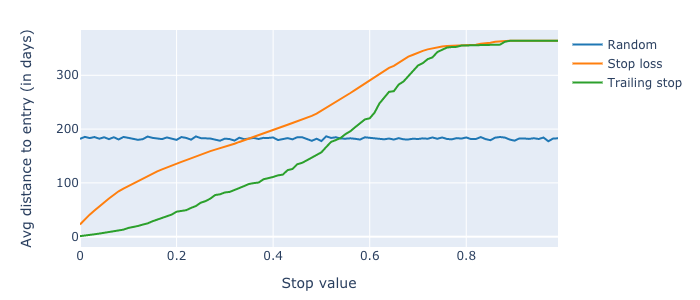

CPU times: user 9.47 s, sys: 229 ms, total: 9.7 s
Wall time: 9.8 s


In [36]:
%%time
# And what is the average distance to the entry signal?
@njit
def map_func_nb(col, entry_i, exit_i):
    return exit_i - entry_i # distance

@njit
def reduce_func_nb(col, a):
    return np.nanmean(a) # average of all distances

pd.DataFrame({
    'Random': entries.vbt.signals.map_reduce_between(
        other=rand_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Stop loss': entries.vbt.signals.map_reduce_between(
        other=stop_loss_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Trailing stop': entries.vbt.signals.map_reduce_between(
        other=trail_stop_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean()
}).vbt.scatter(xaxis_title='Stop value', yaxis_title='Avg distance to entry (in days)').show_png()

In [37]:
%%time
# Calculate portfolio performance
# Performance of plain holding
hold_portfolio = vbt.Portfolio.from_signals(price, entries, exits, freq=freq)

hold_performance = hold_portfolio.total_return

print(hold_performance.shape)
print(hold_performance.mean())

(366000,)
0.015026763536100395
CPU times: user 6.47 s, sys: 5.56 s, total: 12 s
Wall time: 15.8 s


In [38]:
%%time
# Performance of trading with random exits
rand_portfolio = vbt.Portfolio.from_signals(price, entries, rand_exits, freq=freq)

rand_performance = rand_portfolio.total_return

print(rand_performance.shape)
print(rand_performance.mean())

(366000,)
0.109861832420094
CPU times: user 9.28 s, sys: 14.7 s, total: 24 s
Wall time: 34.6 s


In [39]:
%%time
# Performance of trading with stop loss
stop_loss_portfolio = vbt.Portfolio.from_signals(price, entries, stop_loss_exits, freq=freq)

stop_loss_performance = stop_loss_portfolio.total_return

print(stop_loss_performance.shape)
print(stop_loss_performance.mean())

(366000,)
-0.04449396993638241
CPU times: user 12.6 s, sys: 15.4 s, total: 28 s
Wall time: 40.6 s


In [40]:
%%time
# Performance of trading with trailing stop 
trail_stop_portfolio = vbt.Portfolio.from_signals(price, entries, trail_stop_exits, freq=freq)

trail_stop_performance = trail_stop_portfolio.total_return

print(trail_stop_performance.shape)
print(trail_stop_performance.mean())

(366000,)
0.005638921858545374
CPU times: user 13 s, sys: 16 s, total: 29 s
Wall time: 45.9 s


In [41]:
# Plot performance of each strategy depending on the stop value and trend
# Trend is just the net return of this time period
net_return = (price.iloc[-1, :] - price.iloc[0, :]) / price.iloc[0, :]

# Widgets
assets = net_return.index.get_level_values('asset_name')
asset_dropdown = ipywidgets.Dropdown(
    options=['All'] + asset_names,
    value='All'
)
trend_dropdown = ipywidgets.Dropdown(
    options=['All', 'Positive', 'Negative'],
    value='All'
)
dates = net_return.index.get_level_values('range_start')
date_range_slider = ipywidgets.SelectionRangeSlider(
    options=dates.unique(),
    index=(0, len(dates.unique())-1),
    orientation='horizontal',
    readout=False
)
date_range_label = ipywidgets.Label()
scatter_fig = vbt.plotting.create_scatter(
    trace_names=['Holding', 'Random', 'Stop Loss', 'Trailing Stop'],
    x_labels=stops, 
    xaxis_title='Stop value', 
    yaxis_title='Avg total return')
scatter_img = ipywidgets.Image(
    format='png',
    width=scatter_fig.layout.width,
    height=scatter_fig.layout.height
)

# Update function
def update_scatter(*args, **kwargs):
    trend = trend_dropdown.value
    asset = asset_dropdown.value
    date_range = date_range_slider.value
    
    # Build boolean mask based on selected values
    trend_mask = None
    asset_mask = None
    if trend == 'Positive':
        trend_mask = net_return.values > 0
    elif trend == 'Negative':
        trend_mask = net_return.values < 0
    if asset != 'All':
        asset_mask = assets == asset
    mask = (dates >= date_range[0]) & (dates <= date_range[1])
    if trend_mask is not None:
        mask = mask & trend_mask
    if asset_mask is not None:
        mask = mask & asset_mask
    
    # Update graph
    vbt.plotting.update_scatter_data(
        scatter_fig,
        np.asarray([
            hold_performance[mask].groupby(stop_cols[mask]).mean(),
            rand_performance[mask].groupby(stop_cols[mask]).mean(),
            stop_loss_performance[mask].groupby(stop_cols[mask]).mean(),
            trail_stop_performance[mask].groupby(stop_cols[mask]).mean()
        ]).transpose()
    )
    scatter_img.value = scatter_fig.to_image(format="png")
    
    # Update date range label
    date_range_label.value = '{:%d %b %Y} - {:%d %b %Y}'.format(date_range[0], date_range[1])

# Hooks
asset_dropdown.observe(update_scatter, names='value')
trend_dropdown.observe(update_scatter, names='value')
date_range_slider.observe(update_scatter, names='value')
update_scatter()

# Widget hierarchy
dashboard = ipywidgets.VBox([
    ipywidgets.HBox([
        ipywidgets.Label('Asset:'),
        asset_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Trend:'),
        trend_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Date range:'),
        date_range_slider,
        date_range_label
    ]),
    scatter_img
])
dashboard

Amazing how similar is the picture for each asset!

In [42]:
dashboard.close() # after using, release memory and notebook metadata